# This notebook is a case study for parallelization in python

First, we define a slow function, which we want to loop over and a list with values to execute the function for:

In [1]:
import numpy as np
from time import sleep
import time

def slowfunc(x):
    sleep(1)  # Wait 1 second
    return x**2  # Return x^2

vals = np.linspace(0, 100, 101)  # List with values between 0 and 100 to square

Next, let us use regular list comprehension to calcualte the results of slowfunc(vals) in a sequential manner:

In [2]:
st = time.time()  # Get starting time
results_seq = [slowfunc(i) for i in vals]  # Perform calculation loop
runtime = time.time() - st  # Get runtime
print(time.strftime("%H:%M:%S", time.gmtime(runtime)))


00:01:41


This takes around 101s (sleep time plus 1s overhead from the actual calculation). Let us now try to use parallelization to reduce the runtime.

First, we use the joblib library:

In [3]:
import joblib
from joblib import delayed, Parallel

number_of_cpu = joblib.cpu_count()  # get number of available cores

delayed_funcs = [delayed(slowfunc)(i) for i in vals]  # Define action to be parallelized
parallel_pool = Parallel(n_jobs=number_of_cpu, verbose=5)  # Define parallel pool, default settings
# Note: The verbose parameter defines if progress reports are printed duting the calculations

st = time.time()  # Get starting time
results_joblib = parallel_pool(delayed_funcs)  # Perform calculation
runtime = time.time() - st  # Get runtime
sleep(0.5)
print(time.strftime("%H:%M:%S", time.gmtime(runtime)))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:   16.5s finished


00:00:16


We have been able to reduce to reduce the total runtime of the loop down to 16s using 8 cores. Let us now check if the results match:

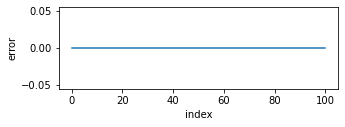

In [4]:
import matplotlib.pyplot as plt

# Subtract the two result lists, should be 0 for all values:
test = np.asarray(results_seq)-np.asarray(results_joblib)

# Visualize test results:
plt.figure(figsize=(5,1.5))
plt.plot(test)
plt.xlabel('index')
plt.ylabel('error')
plt.show()

We find the results to be in the correct order.

The default backend for joblib is 'loky'. Loky is based on multiprocessing and thus uses separate cores. Different backend options include 'multiprocessing' or 'threading'. Here, it should be noted that 'threading' is fundamentally different from 'loky' and 'multiprocessing' as it is a multithreading based approach.

To visualize that, let us compare the runtime of the 'loky' and 'threading' backends:

In [5]:
# Let us begin with the default backend, loky:
delayed_funcs = [delayed(slowfunc)(i) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
results_joblib = Parallel(n_jobs=-1, verbose=5, backend='loky')(delayed_funcs)  # Run calculation
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('loky runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))


# Next, we test multithreading:
delayed_funcs = [delayed(slowfunc)(i) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
# Run calculation:
results_joblib = Parallel(n_jobs=-1, verbose=5, backend='threading')(delayed_funcs)
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('threading runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.1s finished


loky runtime: 00:00:13


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.0s finished


threading runtime: 00:00:13


Interestingly, both cases result the same, reduced runtime, even though multithreading is no true form of parallelization. This may be a result of the 'slow' part of our process being a wait time and not CPU bound. As a consequence, our process is mostly I/O bound and benefits from multithreading.


Another option makes use of the multiprocessing package instead of using the seemingly more convenient joblib wrapper. The multiprocessing package can be used to manually spawn and close new processes. In Jupyter notebook, however, this does not fully work, see [here](https://stackoverflow.com/questions/71098960/attributeerror-cant-get-attribute-starfield-solve-on-module-main-bui) for a workaround.

The example below (should) work outside jupyter notebook/IPython. To make it work in jupyter, the function to be parallelized would need to be loaded in from an external module (a .py file). Because in the notebook this throws an error, we use if False to prevent the code from executing.

In [6]:
if False:
    import multiprocessing as mp

    pool = mp.Pool(mp.cpu_count())  # Get number of available cores
    st = time.time()  # Get starting time
    result_mp = pool.map(slowfunc, vals)  # Run calculation
    runtime = time.time() - st  # Get runtime
    print('multiprocessing runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))



Now let us return to joblib and try a more complex example.

First, instead of parallelizing a loop containing a function, we introduce a class object:

In [7]:
# We define a class that when initialized performs a slow operation:
class SlowClass:
    """ Takes a value, waits one second then squares it """
    result = []
    def __init__(self, value):
        sleep(1)
        self.result = value**2

Let us now try to reproduce the previous example using this class instead of a function:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.1s finished


runtime: 00:00:13


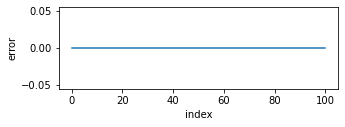

In [8]:
delayed_funcs = [delayed(SlowClass)(i) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
# Run calculation:
result_objects = Parallel(n_jobs=-1, verbose=5)(delayed_funcs)
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

# Now, from result_objects, we can construct an array with the results:
results_class = [i.result for i in result_objects]
test = np.asarray(results_seq) - np.asarray(results_class) 

# Visualize test results:
plt.figure(figsize=(5,1.5))
plt.plot(test)
plt.xlabel('index')
plt.ylabel('error')
plt.show()


Again, we get the desired result at essentially the same computation time comapred to usinf functions in the parallel process. 

Next, we will tackle a problem that can occur when QmeQ based fits to experimental data are considered: A class instance is first initialized and then certain parameters are updated in each iteration of the loop to be parallelized. Then, by using return values, we want to directly populate our results array with a function that inherits the class.

In [9]:
# Let's first redefine our class tot ake two inpiut variables:
class SlowClass:
    """ Takes a value, waits one second then squares it """
    def __init__(self, value, exponent):
        sleep(1)
        self.result = value**exponent

# And now we once more run the calculation using joblib:
delayed_funcs = [delayed(SlowClass)(i, 1) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
# Run calculation:
result_objects = Parallel(n_jobs=-1, verbose=5)(delayed_funcs)
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

# Now, from result_objects, we can construct an array with the results:
results_class = [i.result for i in result_objects]
print(results_class)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.1s finished


runtime: 00:00:13
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


Two input parameters cause no problem. 

Now, let us build a more complex example. We want to have the calculation itself encoded in a class. This class will have an attribute, which we want to access and change between different calculations. The class and calculation is to be embedded in a function.
This example essentially mirrors how we use QmeQ to fit experimental data.


In [10]:
# First, we define the class:
class AdvancedSlowClass:
    """
    Initialized with value and exponent. Result attribute = value^exponent
    Exponent can be updayted with UpdateExp method
    calculate method allows to calculate result for a given new value
    """
    exponent = 2
    def __init__(self, value, exp):
        self.exponent = exp
        sleep(1)
        self.result = value**self.exponent
    def UpdateExp(self, exp):
        self.exponent = exp
    def calculate(self, value):
        sleep(1)
        self.result = value**self.exponent

# Initialize an instance of the class:
Class_Instance = AdvancedSlowClass(0, 2)

# Next, we want to write a function which takes the class instance and a value as input and returns the class attribute 'result':
def ClassToValue(ClassInstance, value):
    ClassInstance.calculate(value)
    return ClassInstance.result


Let us first run the code for our exemplary array in a sequential manner without parallel computation:

runtime: 00:01:41


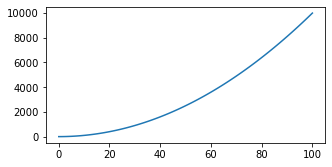

In [11]:
st = time.time()  # Get starting time
results_seq_class = [ClassToValue(Class_Instance, i) for i in vals]
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

# Check the results with a plot:
plt.figure(figsize=(5,2.5))
plt.plot(vals, results_seq_class)
plt.show()

Now, we speed up the calculation by using joblib to parallelize the same calculation. We attempt this for different values of exponents while maintaining the same class instance to test the capabilities of this approach:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.1s finished


runtime: 00:00:13


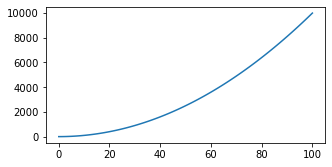

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   13.1s finished


runtime: 00:00:13


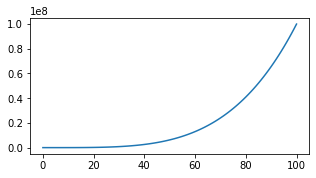

In [12]:
# We start with exponent = 2. This is already set up from the previous calculation:
delayed_funcs = [delayed(ClassToValue)(Class_Instance, i) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
# Run calculation:
results = Parallel(n_jobs=-1, verbose=5)(delayed_funcs)
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

# Check the results with a plot:
plt.figure(figsize=(5,2.5))
plt.plot(vals, results)
plt.show()


# Update exponent:
Class_Instance.UpdateExp(4)
# And repeat:
# We start with exponent = 2. This is already set up from the previous calculation:
delayed_funcs = [delayed(ClassToValue)(Class_Instance, i) for i in vals]  # Define action to be parallelized
st = time.time()  # Get starting time
# Run calculation:
results = Parallel(n_jobs=-1, verbose=5)(delayed_funcs)
runtime = time.time() - st  # Get runtime
sleep(.5)  # Use short sleep time for clean output print
print('runtime: {}'.format(time.strftime("%H:%M:%S", time.gmtime(runtime))))

# Check the results with a plot:
plt.figure(figsize=(5,2.5))
plt.plot(vals, results)
plt.show()

With this working, we have all the tools at hand to parallelize QmeQ fits as well as the noise analysis script.